# Guided-LDA Topic Modeling 

This notebook implements topic modeling using [guided or seeded LDA](https://github.com/vi3k6i5/GuidedLDA)

## Imports

In [20]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import pickle
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import guidedlda
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from collections import Counter
pd.set_option('display.width',-1)

In [21]:
# run some files containing custom functions
%run -i '../scripts/helper_functions.py'

In [3]:
# load data
df = pd.read_csv('../data/all_data.csv')
df.head()

,reviews,rating,company
0,Great card! We get cash back for our grocery a...,4.0,American Express Blue Cash Preferred
1,While traveling we had to keep calling the Cre...,1.0,Credit One Bank
2,Great card to have! Love all the additional cr...,5.0,Capital One Quicksilver Rewards
3,no tengo tanta experiencia asi que no puedo da...,2.0,Citi Double Cash Card
4,This is a basic credit card. The cash back dea...,4.0,Bank of America Cash Rewards Credit Card


In [32]:
df.company.unique()

array(['American Express Blue Cash Preferred ', 'Credit One Bank',
       'Capital One Quicksilver Rewards', 'Citi Double Cash Card',
       'Bank of America Cash Rewards Credit Card',
       'Capital One Venture Rewards', 'Costco Anywhere Visa Card by Citi',
       'Merrick Bank', 'Barclays Bank', 'Citi Diamond Preferred Card',
       'American Express Business Gold Rewards Credit Card',
       'Citi Platinum World Elite', 'Chase Amazon Reward Visa',
       'PayPal Credit', 'Citi Simplicity Card', 'Discover it Cash Back',
       'Sears Credit Card', 'Target Credit Card',
       'American Express Platinum Card', 'Capital One Platinum',
       'TD Cash Visa Credit Card', 'Premier Bankcard', 'Eppicard',
       'Chase Freedom Unlimited',
       'Bank of America Travel Rewards Credit Card',
       'Discover it Secured', 'Discover it Miles', 'Rogers MASTERCARD',
       'OpenSky Secured Visa Credit Card',
       'Chase Sapphire Preffered Card', 'Capital One Secured Credit Card',
       'Capi

In [5]:
df.shape

(25708, 3)

In [6]:
# Remove wide space in review texts
df['reviews']  = df['reviews'].apply(detokenizer)
df.to_csv('../data/all_data.csv', index = False) # save as csv file

In [25]:
# reload data
df = pd.read_csv('../data/all_data.csv')

## Reviews  to sentences

In [8]:
# Converts reviews to sentences and to dataframe
result = review_to_sent(df, 'reviews', 'company')
df_rev_sen = pd.DataFrame({'sentence': result[0], 'company': result[1]}) 

In [9]:
df_rev_sen.shape

(111357, 2)

## Vader Sentiment Analysis

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 

In [19]:
def score(sentence):
    """Returns the compound polarity (sentiment) score of each senetence"""
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(sentence)
    return score['compound']

In [20]:
# Sentiment of each sentence
df_rev_sen['sentiment'] = df_rev_sen.sentence.apply(score)

In [21]:
# Sort and save to csv file
df_rev_sen = df_rev_sen.sort_values(['company','sentiment'], ascending = False).reset_index(drop=True)
df_rev_sen.to_csv('../data/sentence.csv', index = False)

In [18]:
# Reload saved data
df_sentence = pd.read_csv('../data/sentence.csv') 
df_sentence.head()

,sentence,company,sentiment
0,I CALLED AND ASKED THEM WHY I WAS GETTING INTE...,Walmart MASTERCARD,0.8647
1,Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481
2,I must note that I had also received 2 previou...,Walmart MASTERCARD,0.8225
3,After 6 weeks and a few major purchases I was ...,Walmart MASTERCARD,0.7943
4,I have the Walmart Mastercard for over 2 years...,Walmart MASTERCARD,0.7845


In [58]:
df_sentence.shape

(111357, 3)

In [40]:
df_sentence[df_sentence.company =='Capital One Quicksilver Rewards'].sentence.loc[78410]

'After using other credit cards with travel rewards benefits, Capital One Venture has the best and easiest to use benefit program, hands down.'

## Data Pre-processing

In [15]:
# By inspection, I will add more stopwords to the default nltk stopwords
my_stop_words = ['capital','america', 'redcard', 'target','amazon', 'card', 'credit','merrick', 'discover', 'citi',
                 'amex', 'express', 'go', 'paypal', 'chase', 'american', 'one', 'would', 'ask','really', 
                 'get', 'know', 'express', 'ever','use','say', 'recently', 'also', 'always', 'give',  'tell', 
                 'take', 'never', 'costco', 'time', 'make', 'try','number', 'send', 'new', 'even',
                 'sony', 'us', 'husband', 'car', 'capitol', 'wife', 'book','could','okay', 'mastercard', 'want',
                 'honestly', 'eppicard', 'need', 'family', 'cap', 'another', 'line', 'com', 'fico', 'quicksilver',
                'link', 'sear', 'pay', 'may', 'company', 'bank', 'call', 'account', 'receive','told', 'day', 'well',
                'think', 'look', 'sure', 'easy', 'money', 'people','business', 'review', 'something', 'come','away']

stop_words = stopwords.words('english')
stop_words.extend(my_stop_words)

In [26]:
def word_count(text):
    """Plot the most frequency words in the corpus"""
    all_reviews = ' '.join(text) # join all reviews
    token_count = Counter(my_tokenizer(all_reviews)) # count each word
    common_words =  dict( token_count.most_common(n=25) ) # count most common 20 words
    freq_plot = pd.Series(common_words, index=None).plot(kind = 'bar', figsize=(10,5))
    plt.ylabel('count')
    #plt.savefig('../figures/fig2.pdf')

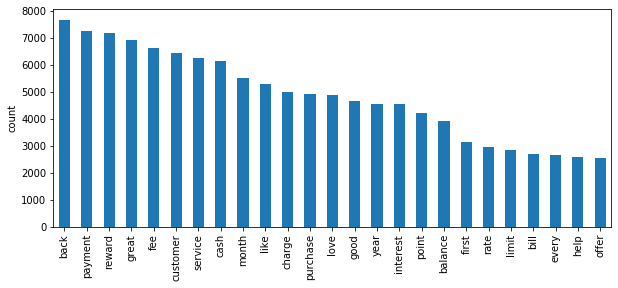

In [27]:
word_count(df_sentence.sentence)

# Topic Modeling with LDA

In [20]:
X, vocab, word2id = doc_term_matrix(df_sentence, 'sentence')

In [21]:
X.shape

(111357, 12715)

## 1. Sklearn LDA

In [22]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [23]:
lda = LDA(n_components=10, learning_method='batch')
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [24]:
lda.components_.shape

(10, 12715)

In [25]:
topics = ['topic{}'.format(i) for i in range(lda.components_.shape[0])]
components = pd.DataFrame(lda.components_.T, index=vocab, columns = topics)/len(X)
n_top_words = 10
for i, topic_dist in enumerate(topics):
    topic_words = components[topics[i]].sort_values(ascending=False)[:n_top_words].index
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: payment statement mail sent week state letter later check show
Topic 1: fee year first annual problem month charge since dollar ago
Topic 2: payment charge bill late fee due online transaction still paid
Topic 3: apply fraud charge approve happy accepted decide order application decline
Topic 4: interest balance rate limit month help high score increase low
Topic 5: back reward cash point purchase like travel great love earn
Topic 6: customer service great love good far helpful excellent benefit complaint
Topic 7: bad start experience worth like nothing secure rebuild little read
Topic 8: recommend issue online anyone definitely good highly thank simple others
Topic 9: phone good work app someone cancel website understand person speak


## 2. Guided LDA

In [26]:
# Normal LDA without seeding
model = guidedlda.GuidedLDA(n_topics=12, n_iter=100, random_state=7, refresh=20)
model.fit(X)

INFO:guidedlda:n_documents: 111357
INFO:guidedlda:vocab_size: 12715
INFO:guidedlda:n_words: 538584
INFO:guidedlda:n_topics: 12
INFO:guidedlda:n_iter: 100
INFO:guidedlda:<0> log likelihood: -6547344
INFO:guidedlda:<20> log likelihood: -4188181
INFO:guidedlda:<40> log likelihood: -4118918
INFO:guidedlda:<60> log likelihood: -4033522
INFO:guidedlda:<80> log likelihood: -3981162
INFO:guidedlda:<99> log likelihood: -3948241


In [27]:
topic_word = model.topic_word_
n_top_words = 10
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: customer service great good help bad experience recommend problem year
Topic 1: payment charge check bill close sent phone information letter mail
Topic 2: reward back cash great recommend interest rate good month like
Topic 3: fee payment charge month late balance interest paid bill year
Topic 4: back cash reward love point great purchase travel like earn
Topic 5: rate interest high great good fee like reward love low
Topic 6: reward fee purchase like back great point cash year good
Topic 7: payment charge month back close year cancel purchase phone wait
Topic 8: fee payment month limit year interest balance charge score increase
Topic 9: reward great back cash love point travel purchase like good
Topic 10: customer service online payment app website phone problem great issue
Topic 11: payment charge bill mail online back phone email due month


In [28]:
# Guided LDA with seed topics.
seed_topic_list = [['online', 'app','website','apply', 'approve', 'online', 'offer', 'application'],
                    ['customer','service','good', 'great', 'helpful', 'love', 'help', 'excellent'],
                   [ 'payment', 'fee', 'charge', 'late', 'month', 'due', 'score'],
                    ['close', 'cancel',  'closure', 'charge'],
                    ['high', 'interest', 'rate',  'apr', 'annual', 'fee', 'yearly', 'limit'],
                    ['recommend','good', 'love','like', 'great'],
                    ['fraud', 'fraudulent','scam', 'terrible'],
                    ['reward', 'point','cash', 'back', 'purchase','good', 'love'], 
                    ['mile', 'travel', 'point', 'airline', 'good', 'love'],
                    ['build', 'rebuild', 'limit']]
                    
model = guidedlda.GuidedLDA(n_topics=10, n_iter=1000, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id
        
model.fit(X, seed_topics=seed_topics, seed_confidence=0.15)

INFO:guidedlda:n_documents: 111357
INFO:guidedlda:vocab_size: 12715
INFO:guidedlda:n_words: 538584
INFO:guidedlda:n_topics: 10
INFO:guidedlda:n_iter: 1000
INFO:guidedlda:<0> log likelihood: -6394427
INFO:guidedlda:<20> log likelihood: -4078054
INFO:guidedlda:<40> log likelihood: -3968008
INFO:guidedlda:<60> log likelihood: -3912541
INFO:guidedlda:<80> log likelihood: -3882386
INFO:guidedlda:<100> log likelihood: -3862220
INFO:guidedlda:<120> log likelihood: -3848003
INFO:guidedlda:<140> log likelihood: -3840018
INFO:guidedlda:<160> log likelihood: -3831811
INFO:guidedlda:<180> log likelihood: -3827367
INFO:guidedlda:<200> log likelihood: -3822107
INFO:guidedlda:<220> log likelihood: -3818415
INFO:guidedlda:<240> log likelihood: -3815460
INFO:guidedlda:<260> log likelihood: -3813544
INFO:guidedlda:<280> log likelihood: -3810635
INFO:guidedlda:<300> log likelihood: -3809901
INFO:guidedlda:<320> log likelihood: -3807698
INFO:guidedlda:<340> log likelihood: -3807068
INFO:guidedlda:<360> lo

In [32]:
# joblib.dump(model, 'trained_lda.pkl')

['trained_lda.pkl']

In [95]:
# trained_model = joblib.load('trained_lda.pkl')

In [31]:
n_top_words =14
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print('Topic {}: {}'.format(i, ' '.join(topic_words)))

Topic 0: payment online app website purchase bill check like statement love charge email balance phone
Topic 1: service customer great good love helpful problem issue excellent experience friendly bad app help
Topic 2: payment fee charge month late balance paid due bill interest close full statement date
Topic 3: customer service like bad understand cancel speak help talk someone person problem phone close
Topic 4: interest fee rate high annual balance low month great apr year offer transfer reward
Topic 5: recommend great good love anyone reward highly help definitely like experience best first build
Topic 6: back charge phone address mail sent letter customer service issue payment cancel state close
Topic 7: back cash reward purchase love point great like earn gas month bonus offer every
Topic 8: travel point reward love great purchase like fee mile lot good earn transaction accepted
Topic 9: limit year score increase month payment help good apply first approve start since ago


## Document-topic distributions

In [33]:
trained_model = joblib.load('trained_lda.pkl') # load trained model

In [34]:
# List of keywords
word_list = [', '.join(np.array(vocab)[list(reversed(X[i,:].argsort()))[0:10]]) for i in range(len(X))]

In [35]:
# Extract the topic vector
doc_topic = trained_model.transform(X)
# num_topic = [doc_topic[i].argmax() for i in range(len(X))] #  extract maximum topic number

In [36]:
columns10 = ['topic {}'.format(i) for i in range(10)]
topic_vector = pd.DataFrame(doc_topic, columns = columns10)
topic_vector.round(2).head()

,topic 0,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9
0,0.0,0.00,0.69,0.00,0.3,0.0,0.00,0.00,0.00,0.00
1,0.0,0.01,0.00,0.00,0.0,0.0,0.00,0.96,0.02,0.00
2,0.0,0.12,0.00,0.05,0.0,0.0,0.43,0.00,0.00,0.39
3,0.0,0.00,0.37,0.00,0.0,0.0,0.00,0.00,0.00,0.62
4,0.0,0.00,0.53,0.00,0.0,0.0,0.46,0.00,0.00,0.00


In [37]:
# Assign topic if it is more than 70% dominant
num_topic = topic_threshold(doc_topic, topic_vector, threshold =0.7)

In [45]:
# Topic, keywords, sentence dataframe
df_doc_topic = pd.DataFrame({'topics': num_topic, 'keywords': word_list})
df_doc_topic['sentences'] = df_sentence['sentence']
df_doc_topic['creditcards'] = df_sentence['company']
df_doc_topic['sentiments'] = df_sentence['sentiment']

In [46]:
# Mean sentiment for each credit card
# df_doc_topic['mean_sentiments'] = df_doc_topic['creditcards']
# df_doc_topic['mean_sentiments'] = df_doc_topic['mean_sentiments'].map(dict(round(mean_senti,2)))

In [47]:
# Drop sentence with no topic
df = df_doc_topic[df_doc_topic['topics'] != 'None'].reset_index(drop = True)
df.head()

,topics,keywords,sentences,creditcards,sentiments
0,7,"easily, walmart, excellent, purchase, reward, ...",Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481
1,5,"maintain, wise, several, great, relationship, ...",I have several credit cards and maintain a gre...,Walmart MASTERCARD,0.7717
2,5,"start, building, great, œentry, extranjera, ex...",They are also a great start to building your c...,Walmart MASTERCARD,0.7717
3,5,"start, first, positive, reward, walmart, exten...",First I'll start with the positives about Walm...,Walmart MASTERCARD,0.7579
4,9,"pre, approve, limit, loyal, start, letter, sin...",I have had this card since 2014... started wit...,Walmart MASTERCARD,0.7269


In [48]:
df.shape

(69982, 5)

In [49]:
topic_dict ={0: 'Online Experience',
             1: 'Customer Service',
             2: 'Bill Disputes',
             3: 'Customer Service',
             4: 'Interest Rate',
             5: 'User Recommendation',
             6: 'Fraud Issues',
             7: 'Cash Back and Rewards',
             8: 'Travel Rewards',
             9: 'Build or Rebuild Credit'}

In [50]:
df.topics = df.topics.map(topic_dict)

In [51]:
df.to_csv('../data/creditcard_topics.csv', index = False)

In [7]:
df = pd.read_csv('../data/creditcard_topics.csv')

In [8]:
df.head()

,topics,keywords,sentences,creditcards,sentiments
0,Cash Back and Rewards,"easily, walmart, excellent, purchase, reward, ...",Excellent rewards and redeem easily when makin...,Walmart MASTERCARD,0.8481
1,User Recommendation,"maintain, wise, several, great, relationship, ...",I have several credit cards and maintain a gre...,Walmart MASTERCARD,0.7717
2,User Recommendation,"start, building, great, œentry, extranjera, ex...",They are also a great start to building your c...,Walmart MASTERCARD,0.7717
3,User Recommendation,"start, first, positive, reward, walmart, exten...",First I'll start with the positives about Walm...,Walmart MASTERCARD,0.7579
4,Build or Rebuild Credit,"pre, approve, limit, loyal, start, letter, sin...",I have had this card since 2014... started wit...,Walmart MASTERCARD,0.7269


In [12]:
df.sentences.loc[0]

'Excellent rewards and redeem easily when making purchases in Walmart stores.'

In [54]:
# Put the result in a dataframe
topics, card_list, topic_sentiment = credit_card(df)
card_data = pd.DataFrame({'topics': topics, 'credit_card': card_list, 'topic_sentiment':topic_sentiment})
card_data = card_data.sample(frac=1).reset_index(drop= True)
card_data.head()

,topics,credit_card,topic_sentiment
0,Build or Rebuild Credit,Capital One Secured Credit Card,0.43
1,Bill Disputes,Aspire Visa,-0.11
2,Bill Disputes,Walmart MASTERCARD,-0.06
3,User Recommendation,Citi Diamond Preferred Card,0.48
4,Cash Back and Rewards,Capital One Venture Rewards,0.56


In [55]:
card_data.shape

(354, 3)

In [930]:
import sqlite3
import os

In [971]:
# Put the data in a database
if os.path.exists('../data/creditcard1.db'):
    os.remove('../data/creditcard1.db')

conn = sqlite3.connect('../data/creditcard1.db')
c = conn.cursor()
card_data.to_sql('creditcard', con=conn, index = False, dtype = {'topics': 'TEXT', 
                                                         'credit_card': 'TEXT','topic_sentiment': 'REAL'})
conn.commit()

In [972]:
# Query the database
data = c.execute("SELECT credit_card, MAX(topic_sentiment)\
                    FROM creditcard \
                    WHERE topics = 'Build or Rebuild Credit'; ").fetchall()
data

[('Discover it Secured', 0.62)]